# Deep Q-Network implementation

This notebook shamelessly demands you to implement a DQN - an approximate q-learning algorithm with experience replay and target networks - and see if it works any better this way.

In [1]:
import gym
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
%matplotlib inline

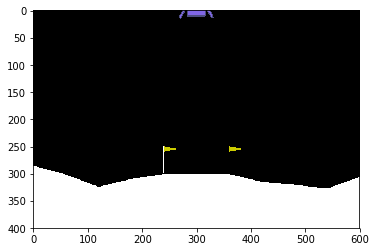

In [2]:
env = gym.make("LunarLander-v2")
env.reset()
img = env.render(mode='rgb_array')
env.close()
plt.imshow(img)

In [3]:
import torch, torch.nn as nn
import torch.nn.functional as F

In [4]:
class DQNAgent():
    def __init__(self, state_shape, n_actions,model, epsilon=0):
        """A simple DQN agent"""
        self.epsilon = epsilon
        self.n_actions = n_actions
        self.state_shape= state_shape
        self.model = model

    def get_qvalues(self, state):
        """
        state is observation from gym environment
        pytorch needs [batch,s], so add a batch dim in state
        """
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        s = torch.from_numpy(np.expand_dims(state,axis=0))
        with torch.no_grad():
            q = self.model.forward(s)
        return np.squeeze(q.data.numpy(),axis=0)
    
    def sample_action(self, qvalues):
        """pick actions given qvalues. Uses epsilon-greedy exploration strategy. """
        
        p = np.ones(self.n_actions,dtype=np.float) * self.epsilon/self.n_actions
        p[qvalues.argmax(axis=-1)] += 1-self.epsilon
        action = np.random.choice(n_actions, p=p)
        return action

### Building a network

We now need to build a neural network that can map images to state q-values. This network will be called on every agent's step

In [5]:
class MLModel(nn.Module):
    def __init__(self,input_size,output_size):
        super(MLModel, self).__init__()
        self.layer1 = nn.Linear(input_size,64)
        self.layer2 = nn.Linear(64,128)
        self.output = nn.Linear(128,output_size)

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.output(x)

### Construct train & evaluation 



Now let's try out our agent to see if it raises any errors.

In [32]:
def evaluate(env, agent, n_games=1, greedy=True,render=False):
    """ Plays n_games full games. If greedy, picks actions as argmax(qvalues). Returns mean reward. """
    t_max = env.spec.timestep_limit or 10000
    rewards = []
    old_epsilon = agent.epsilon
    if greedy:
        agent.epsilon = 0.0
    
    for _ in range(n_games):
        s = env.reset()
        reward = 0
        for _ in range(t_max):
            qvalues = agent.get_qvalues(s)
            action = agent.sample_action(qvalues)
            s, r, done, _ = env.step(action)
            if render:
                env.render()
            reward += r
            if done: break
                
        rewards.append(reward)
    
    if render:
        env.close()
    
    agent.epsilon = old_epsilon
    
    return np.mean(rewards)

### Experience replay
#### The interface:
* `exp_replay.push(state, action, reward, next_state, done)` - saves (s,a,r,s',done) tuple into the buffer
* `exp_replay.sample(batch_size)` - returns observations, actions, rewards, next_observations and is_done for `batch_size` random samples.
* `len(exp_replay)` - returns number of elements stored in replay buffer.

In [7]:
import random
from collections import namedtuple

Transition = namedtuple('Transition',
                        ('state', 'action', 'reward','next_state','done'))

class ReplayMemory(object):

    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        """Saves a transition."""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    
    def head(self):
        return self.memory[-1]

    def __len__(self):
        return len(self.memory)

### Learning with... Q-learning

Compute Q-learning TD error:

$$ L = { 1 \over N} \sum_i [ Q_{policy_\theta}(s,a) - Q_{reference}(s,a) ] ^2 $$

With Q-reference defined as

$$ Q_{reference}(s,a) = r(s,a) + \gamma \cdot max_{a'} Q_{target}(s', a') $$

Where
* $Q_{target}(s',a')$ denotes q-value of next state and next action predicted by __target_network__
* $s, a, r, s'$ are current state, action, reward and next state respectively
* $\gamma$ is a discount factor defined two cells above.


__Note 1:__ there's an example input below. Feel free to experiment with it before you write the function.
__Note 2:__ compute_td_loss is a source of 99% of bugs in this homework. If reward doesn't improve, it often helps to go through it line by line [with a rubber duck](https://rubberduckdebugging.com/).

In [34]:
def td_loss(target_net,policy_net,states,actions,rewards,next_states,is_dones,GAMMA = 0.99):
    s_ = torch.as_tensor(states)
    a_ = torch.as_tensor(actions)
    r_ = torch.as_tensor(rewards)
    ns_= torch.as_tensor(next_states)
    d_= torch.as_tensor(is_dones)
    not_d_ = 1 - d_
    
    #predict Q values
    predict_q_ = policy_net(s_).gather(dim=1,index=a_.view(-1,1)).squeeze()
    
    #predict Next QValues with target network
    with torch.no_grad():
        predict_next_q_ = target_net(s_)
        predict_v_ = torch.max(predict_next_q_,dim=1)[0] * not_d_
        reference_q_ = r_ + GAMMA * predict_v_
    
    #loss = F.mse_loss(predict_q_,reference_q_)
    loss = F.smooth_l1_loss(predict_q_,reference_q_)
    
    return loss

### Main loop

It's time to put everything together and see if it learns anything.

In [38]:
from tqdm import trange
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

mean_rw_history = []
td_loss_history = []
td_loss_m_history = []
BATCH_SIZE=64
TIME_STEPS=10**5*4
LEARNING_RATE= 0.001

  3%|▎         | 10655/400000 [01:00<44:53, 144.57it/s]

In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
state_dim,n_actions = env.observation_space.shape[0],env.action_space.n

In [49]:
policy_net = MLModel(state_dim,n_actions).to(device)
target_net = MLModel(state_dim,n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())
agent = DQNAgent(state_dim, n_actions,policy_net, epsilon=0.5)
exp_replay = ReplayMemory(10**5)




  6%|▌         | 11398/200000 [02:31<29:58, 104.87it/s]

In [52]:
evaluate(env, agent, n_games=3,render=True)

-33.50115699955324

In [50]:
EPSILON_START = 0.5
EPSILON_END = 0.001
agent.epsilon=EPSILON_START
LEARNING_RATE= 0.0001

buffer size = 100000, epsilon = 0.00170


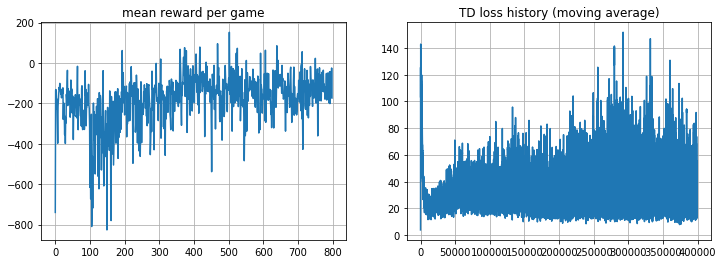

100%|██████████| 400000/400000 [57:23<00:00, 116.18it/s]


In [25]:
optimizer = torch.optim.Adam(policy_net.parameters(),lr= LEARNING_RATE)

# for training
env = gym.make("LunarLander-v2")
# for evaluation
eval_env = gym.make("LunarLander-v2")
s = env.reset()
for i in trange(TIME_STEPS):
    
    # play
    q_values = agent.get_qvalues(s)
    a = agent.sample_action(q_values)
    s_next,r,done, _ = env.step(a)
    
    exp_replay.push(s,a,r,s_next,done)
    
    s = s_next
    
    if done:
        s = env.reset()
    
    if len(exp_replay) < BATCH_SIZE:
        continue
    
    # train
    # < sample data from experience replay>
    transitions = exp_replay.sample(BATCH_SIZE)
    # Transpose the batch (see http://stackoverflow.com/a/19343/3343043 for
    # detailed explanation).
    batch = Transition(*zip(*transitions))
   
    
    # loss = < compute TD loss >
    nd_states= np.array(batch.state,dtype=np.float32)
    nd_actions= np.array(batch.action,dtype=np.int64)
    nd_rewards = np.array(batch.reward,dtype=np.float32)
    nd_next_states = np.array(batch.next_state,dtype=np.float32)
    nd_is_dones = np.array(batch.done).astype(np.float32)

    loss = td_loss(target_net,policy_net,nd_states,nd_actions,nd_rewards,nd_next_states,nd_is_dones)
    
    #< minimize loss by gradient descent >
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    td_loss_history.append(loss.data.numpy())
    
    count = min(len(td_loss_history),100)
    td_loss_m_history.append(np.mean(td_loss_history[-count:]))
    
    # adjust agent parameters
    agent.epsilon -= (EPSILON_START - EPSILON_END)/TIME_STEPS
    if i % 500 == 0:
        #agent.epsilon = max(agent.epsilon * 0.999, 0.01)
        
        
        mean_rw_history.append(evaluate(eval_env, agent, n_games=3))
        
        #Load agent weights into target_network
        target_net.load_state_dict(policy_net.state_dict())
        
    
    #if i % 100 == 0:
        
        clear_output(True)
        print("buffer size = %i, epsilon = %.5f" % (len(exp_replay), agent.epsilon))
        plt.figure(figsize=[12, 4])        
        plt.subplot(1,2,1)
        plt.title("mean reward per game")
        plt.plot(mean_rw_history)
        plt.grid()

        plt.subplot(1,2,2)
        plt.title("TD loss history (moving average)")
        plt.plot(td_loss_m_history)
        plt.grid()
        plt.show()
        
        

buffer size = 100000, epsilon = 0.00170


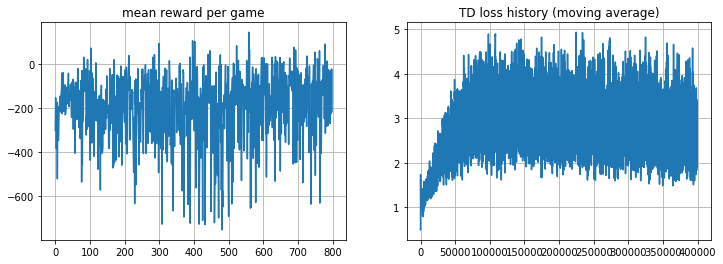







100%|█████████▉| 399501/400000 [1:27:51<00:15, 32.33it/s] 





100%|█████████▉| 399514/400000 [1:27:51<00:11, 41.56it/s]





100%|█████████▉| 399525/400000 [1:27:51<00:09, 50.66it/s]





100%|█████████▉| 399535/400000 [1:27:51<00:07, 58.27it/s]





100%|█████████▉| 399546/400000 [1:27:51<00:06, 66.82it/s]





100%|█████████▉| 399556/400000 [1:27:51<00:06, 72.15it/s]





100%|█████████▉| 399567/400000 [1:27:51<00:05, 79.42it/s]





100%|█████████▉| 399577/400000 [1:27:51<00:05, 80.89it/s]





100%|█████████▉| 399587/400000 [1:27:52<00:04, 84.66it/s]





100%|█████████▉| 399597/400000 [1:27:52<00:04, 86.41it/s]





100%|█████████▉| 399607/400000 [1:27:52<00:04, 87.71it/s]





100%|█████████▉| 399617/400000 [1:27:52<00:04, 85.42it/s]





100%|█████████▉| 399626/400000 [1:27:52<00:04, 85.67it/s]





100%|█████████▉| 399635/400000 [1:27:52<00:04, 84.67it/s]





100%|█████████▉| 399644/400000 [1:27:52<00:04, 84.67it/s]





100%|█████████▉| 399653/400000 [1:27:52<00:04, 8

In [54]:
TIME_STEPS= 10**5*4
EPSILON_START = 0.5
EPSILON_END = 0.001
LEARNING_RATE= 0.001
policy_net = MLModel(state_dim,n_actions).to(device)
target_net = MLModel(state_dim,n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())
agent = DQNAgent(state_dim, n_actions,policy_net, epsilon=EPSILON_START)
exp_replay = ReplayMemory(10**5)

mean_rw_history = []
td_loss_history = []
td_loss_m_history = []

agent.epsilon=EPSILON_START


optimizer = torch.optim.Adam(policy_net.parameters(),lr= LEARNING_RATE)

# for training
env = gym.make("LunarLander-v2")
# for evaluation
eval_env = gym.make("LunarLander-v2")
s = env.reset()
for i in trange(TIME_STEPS):
    
    # play
    q_values = agent.get_qvalues(s)
    a = agent.sample_action(q_values)
    s_next,r,done, _ = env.step(a)
    
    exp_replay.push(s,a,r,s_next,done)
    
    s = s_next
    
    if done:
        s = env.reset()
    
    if len(exp_replay) < BATCH_SIZE:
        continue
    
    # train
    # < sample data from experience replay>
    transitions = exp_replay.sample(BATCH_SIZE)
    # Transpose the batch (see http://stackoverflow.com/a/19343/3343043 for
    # detailed explanation).
    batch = Transition(*zip(*transitions))
   
    
    # loss = < compute TD loss >
    nd_states= np.array(batch.state,dtype=np.float32)
    nd_actions= np.array(batch.action,dtype=np.int64)
    nd_rewards = np.array(batch.reward,dtype=np.float32)
    nd_next_states = np.array(batch.next_state,dtype=np.float32)
    nd_is_dones = np.array(batch.done).astype(np.float32)

    loss = td_loss(target_net,policy_net,nd_states,nd_actions,nd_rewards,nd_next_states,nd_is_dones)
    
    #< minimize loss by gradient descent >
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    td_loss_history.append(loss.data.numpy())
    
    count = min(len(td_loss_history),100)
    td_loss_m_history.append(np.mean(td_loss_history[-count:]))
    
    # adjust agent parameters
    agent.epsilon -= (EPSILON_START - EPSILON_END)/TIME_STEPS
    if i % 500 == 0:
        #agent.epsilon = max(agent.epsilon * 0.999, 0.01)
        
        
        mean_rw_history.append(evaluate(eval_env, agent, n_games=5))
        
        #Load agent weights into target_network
        target_net.load_state_dict(policy_net.state_dict())
       
        
    
    #if i % 100 == 0:
        
        clear_output(True)
        print("buffer size = %i, epsilon = %.5f" % (len(exp_replay), agent.epsilon))
        plt.figure(figsize=[12, 4])        
        plt.subplot(1,2,1)
        plt.title("mean reward per game")
        plt.plot(mean_rw_history)
        plt.grid()

        plt.subplot(1,2,2)
        plt.title("TD loss history (moving average)")
        plt.plot(td_loss_m_history)
        plt.grid()
        plt.show()
        
        if mean_rw_history[-1] >= 200:
            print("Wins")
            break
        
        

In [18]:
torch.save(target_net.state_dict(), "checkpoint.pt")

In [ ]:
policy_net.load_state_dict(torch.load("checkpoint.pt"))

In [55]:
evaluate(eval_env, agent, n_games=1,render=True)

-10.477203830092492

In [28]:
s = eval_env.reset()

In [52]:
q_values=agent.get_qvalues(s)

In [50]:
agent.sample_action(q_values)

3

In [51]:
s,r,done,_ = eval_env.step(3)

In [80]:
def evaluate_(env, agent, n_games=1, greedy=True):
    """ Plays n_games full games. If greedy, picks actions as argmax(qvalues). Returns mean reward. """
    t_max = env.spec.timestep_limit or 10000
    rewards = []
    old_epsilon = agent.epsilon
    actions = []
    q_values = []
    if greedy:
        agent.epsilon = 0.0
    
    for _ in range(n_games):
        s = env.reset()
        reward = 0
        for _ in range(t_max):
            qvalues = agent.get_qvalues(s)
            action = agent.sample_action(qvalues)
            actions.append(action)
            s, r, done, _ = env.step(action)
            reward += r
            rewards.append(r)
            q_values.append(qvalues)
            if done: break
                
        #rewards.append(reward)
    
    agent.epsilon = old_epsilon
    
    return rewards,actions,q_values

In [89]:
agent.model = target_net

In [90]:
r,actions,qs=evaluate_(eval_env, agent, n_games=1)

### Prioritized Replay Memory


In [ ]:
from replay_buffer_buffer_bufferay_buffer import PrioritizedReplayBuffer

In [ ]:
optimizer = torch.optim.Adam(policy_net.parameters())
exp_replay = PrioritizedReplayBuffer(10**4,alpha = 0.5)
# for training
env = gym.make("LunarLander-v2")
# for evaluation
eval_env = gym.make("LunarLander-v2")
s = env.reset()
for i in trange(TIME_STEPS):
    
    # play
    q_values = agent.get_qvalues(s)
    a = agent.sample_action(q_values)
    s_next,r,done, _ = env.step(a)
    
    exp_replay.push(s,a,r,s_next,done)
    
    s = s_next
    
    if done:
        s = env.reset()
    
    if len(exp_replay) < BATCH_SIZE:
        continue
    
    # train
    # < sample data from experience replay>
    nd_states,nd_actions,nd_rewards,nd_next_states,nd_is_dones,_,_ = exp_replay.sample(BATCH_SIZE,beta=0.5)

    # loss = < compute TD loss >


    loss = td_loss(target_net,policy_net,nd_states,nd_actions,nd_rewards,nd_next_states,nd_is_dones)
    
    #< minimize loss by gradient descent >
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    td_loss_history.append(loss.data.numpy())
    
    count = min(len(td_loss_history),100)
    td_loss_m_history.append(np.mean(td_loss_history[-count:]))
    
    # adjust agent parameters
    if i % 500 == 0:
        agent.epsilon = max(agent.epsilon * 0.99, 0.01)
        
        mean_rw_history.append(evaluate(eval_env, agent, n_games=3))
        
        #Load agent weights into target_network
        target_net.load_state_dict(policy_net.state_dict())
        
    
    #if i % 100 == 0:
        
        clear_output(True)
        print("buffer size = %i, epsilon = %.5f" % (len(exp_replay), agent.epsilon))
        plt.figure(figsize=[12, 4])        
        plt.subplot(1,2,1)
        plt.title("mean reward per game")
        plt.plot(mean_rw_history)
        plt.grid()

        plt.subplot(1,2,2)
        plt.title("TD loss history (moving average)")
        plt.plot(td_loss_m_history)
        plt.grid()
        plt.show()
        
        

__ How to interpret plots: __


This aint no supervised learning so don't expect anything to improve monotonously. 
* __ TD loss __ is the MSE between agent's current Q-values and target Q-values. It may slowly increase or decrease, it's ok. The "not ok" behavior includes going NaN or stayng at exactly zero before agent has perfect performance.
* __ mean reward__ is the expected sum of r(s,a) agent gets over the full game session. It will oscillate, but on average it should get higher over time (after a few thousand iterations...). 
 * In basic q-learning implementation it takes 5-10k steps to "warm up" agent before it starts to get better.
* __ buffer size__ - this one is simple. It should go up and cap at max size.
* __ epsilon__ - agent's willingness to explore. If you see that agent's already at 0.01 epsilon before it's average reward is above 0 - __ it means you need to increase epsilon__. Set it back to some 0.2 - 0.5 and decrease the pace at which it goes down.
* Also please ignore first 100-200 steps of each plot - they're just oscillations because of the way moving average works.

At first your agent will lose quickly. Then it will learn to suck less and at least hit the ball a few times before it loses. Finally it will learn to actually score points.

__Training will take time.__ A lot of it actually. An optimistic estimate is to say it's gonna start winning (average reward > 10) after 20k steps. 

But hey, long training time isn't _that_ bad:
![img](https://github.com/yandexdataschool/Practical_RL/raw/master/yet_another_week/_resource/training.png)


### Video

In [ ]:
agent.epsilon=0 # Don't forget to reset epsilon back to previous value if you want to go on training

In [ ]:
#record sessions
import gym.wrappers
env_monitor = gym.wrappers.Monitor(make_env(),directory="videos",force=True)
sessions = [evaluate(env_monitor, agent, n_games=1) for _ in range(100)]
env_monitor.close()

In [ ]:
#show video
from IPython.display import HTML
import os

video_names = list(filter(lambda s:s.endswith(".mp4"),os.listdir("./videos/")))

HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format("./videos/"+video_names[-1])) #this may or may not be _last_ video. Try other indices

## Bonus I (2+ pts)

Implement and train double q-learning.

This task contains of
* Implementing __double q-learning__ or __dueling q-learning__ or both (see tips below)
* Training a network till convergence
  * Full points will be awarded if your network gets average score of >=10 (see "evaluating results")
  * Higher score = more points as usual
  * If you're running out of time, it's okay to submit a solution that hasn't converged yet and updating it when it converges. _Lateness penalty will not increase for second submission_, so submitting first one in time gets you no penalty.


#### Tips:
* Implementing __double q-learning__ shouldn't be a problem if you've already have target networks in place.
  * You will probably need `tf.argmax` to select best actions
  * Here's an original [article](https://arxiv.org/abs/1509.06461)

* __Dueling__ architecture is also quite straightforward if you have standard DQN.
  * You will need to change network architecture, namely the q-values layer
  * It must now contain two heads: V(s) and A(s,a), both dense layers
  * You should then add them up via elemwise sum layer.
  * Here's an [article](https://arxiv.org/pdf/1511.06581.pdf)

## Bonus II (5+ pts): Prioritized experience replay

In this section, you're invited to implement prioritized experience replay

* You will probably need to provide a custom data structure
* Once pool.update is called, collect the pool.experience_replay.observations, actions, rewards and is_alive and store them in your data structure
* You can now sample such transitions in proportion to the error (see [article](https://arxiv.org/abs/1511.05952)) for training.

It's probably more convenient to explicitly declare inputs for "sample observations", "sample actions" and so on to plug them into q-learning.

Prioritized (and even normal) experience replay should greatly reduce amount of game sessions you need to play in order to achieve good performance. 

While it's effect on runtime is limited for atari, more complicated envs (further in the course) will certainly benefit for it.

Prioritized experience replay only supports off-policy algorithms, so pls enforce `n_steps=1` in your q-learning reference computation (default is 10).